In [1]:
# Telecom Churn Prediction

# Step 1: Data Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load sample data
file_path = "C:/Users/pc/Downloads/telecom_churn_data.csv"
df = pd.read_csv(file_path, nrows=5000)

In [5]:
# Step 2: Basic Data Checks
print("Shape of dataset:", df.shape)
print("Missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Shape of dataset: (5000, 226)
Missing values (top 10):
arpu_3g_6                   3720
fb_user_6                   3720
count_rech_2g_6             3720
count_rech_3g_6             3720
arpu_2g_6                   3720
night_pck_user_6            3720
max_rech_data_6             3720
date_of_last_rech_data_6    3720
av_rech_amt_data_6          3720
total_rech_data_6           3720
dtype: int64


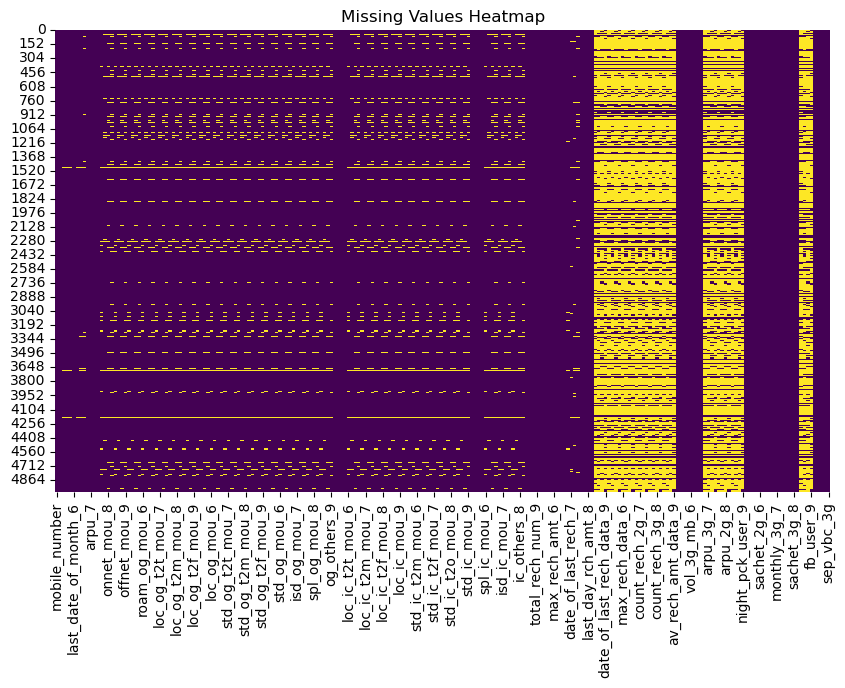

In [7]:
# Visualization of missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


In [9]:
# Step 3: Filter High-Value Customers
# Define total recharge amount for months 6 and 7
recharge_cols = ['total_rech_amt_6', 'total_rech_amt_7']
df['avg_rech_amt_6_7'] = df[recharge_cols].mean(axis=1)
x = df['avg_rech_amt_6_7'].quantile(0.7)
df_high_value = df[df['avg_rech_amt_6_7'] >= x]

print("\nFiltered High-Value Customers:")
print(df_high_value.head())


Filtered High-Value Customers:
    mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
7             6/30/2014            7/31/2014            8/31/2014   
8             6/30/2014            7/31/2014            8/31/2014   
13            6/30/2014            7/31/2014            8/31/2014   
16            6/30/2014            7/31/2014            8/31/2014   
17            6/30/2014            7/31/2014            8/31/2014   

   last_date_of_month_9    arpu_6  ...  fb_user_6  fb_user_7  fb_user_8 

In [11]:
# Step 4: Tag Churn
churn_conditions = (
    (df_high_value['total_ic_mou_9'].fillna(0) == 0) &
    (df_high_value['total_og_mou_9'].fillna(0) == 0) &
    (df_high_value['vol_2g_mb_9'].fillna(0) == 0) &
    (df_high_value['vol_3g_mb_9'].fillna(0) == 0)
)
df_high_value['churn'] = np.where(churn_conditions, 1, 0)

# Drop churn phase columns
df_model = df_high_value.drop(columns=[col for col in df_high_value.columns if '_9' in col])

print("\nData after Churn Tagging:")
print(df_model.head())


Data after Churn Tagging:
    mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
7      7000701601        109             0.0             0.0             0.0   
8      7001524846        109             0.0             0.0             0.0   
13     7002191713        109             0.0             0.0             0.0   
16     7000875565        109             0.0             0.0             0.0   
17     7000187447        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
7             6/30/2014            7/31/2014            8/31/2014  1069.180   
8             6/30/2014            7/31/2014            8/31/2014   378.721   
13            6/30/2014            7/31/2014            8/31/2014   492.846   
16            6/30/2014            7/31/2014            8/31/2014   430.975   
17            6/30/2014            7/31/2014            8/31/2014   690.008   

      arpu_7  ...

In [13]:
# Step 5: Feature Engineering
# Drop identifier and non-numeric columns
non_features = ['mobile_number', 'circle_id', 'last_date_of_month_6', 'last_date_of_month_7',
                'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7',
                'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
                'date_of_last_rech_data_8']
df_model = df_model.drop(columns=[col for col in non_features if col in df_model.columns])

# Impute missing values with median
df_model.fillna(df_model.median(numeric_only=True), inplace=True)

print("\nData after Feature Engineering:")
print(df_model.head())


Data after Feature Engineering:
    loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6    arpu_7  \
7              0.0             0.0             0.0  1069.180  1349.850   
8              0.0             0.0             0.0   378.721   492.223   
13             0.0             0.0             0.0   492.846   205.671   
16             0.0             0.0             0.0   430.975   299.869   
17             0.0             0.0             0.0   690.008    18.980   

      arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  ...  \
7   3171.480        57.84        54.68        52.29        453.43  ...   
8    137.362       413.69       351.03        35.08         94.66  ...   
13   593.260       501.76       108.39       534.24        413.31  ...   
16   187.894        50.51        74.01        70.61        296.29  ...   
17    25.499      1185.91         9.28         7.79         61.64  ...   

    fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g

In [15]:
# Step 6: Modeling
X = df_model.drop(columns=['churn'])
y = df_model['churn']

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Data Shape:")
print(X_train_scaled.shape, X_test_scaled.shape)


Scaled Data Shape:
(1922, 162) (824, 162)


In [17]:
# Step 7: Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("\nLogistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       410
           1       0.93      0.94      0.94       414

    accuracy                           0.93       824
   macro avg       0.93      0.93      0.93       824
weighted avg       0.93      0.93      0.93       824

ROC-AUC: 0.9758218451749735


In [19]:
# Step 8: Feature Importance
coefficients = pd.Series(lr.coef_[0], index=X.columns)
important_features = coefficients.sort_values(key=lambda x: abs(x), ascending=False).head(10)
print("\nTop 10 Important Features:")
print(important_features)


Top 10 Important Features:
total_ic_mou_8       -4.024820
total_og_mou_8       -3.205691
sachet_2g_8          -2.996197
sachet_2g_6          -2.126139
isd_og_mou_7          2.015422
sep_vbc_3g           -1.905636
total_rech_amt_7     -1.733382
total_rech_amt_8      1.608142
total_rech_num_8     -1.595397
last_day_rch_amt_8   -1.582363
dtype: float64


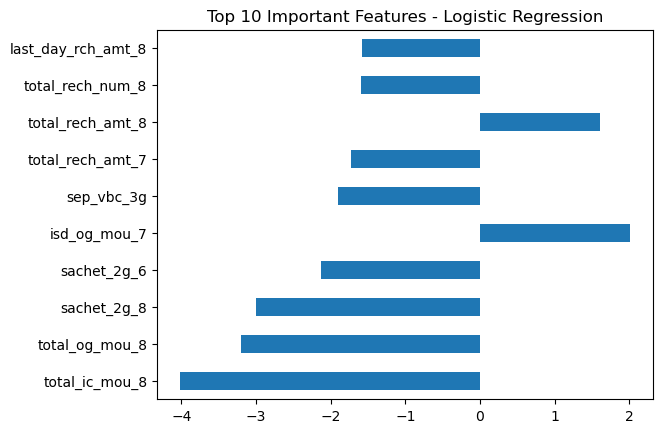

In [21]:
# Visualization of important features
important_features.plot(kind='barh')
plt.title("Top 10 Important Features - Logistic Regression")
plt.show()
